# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

## Word2vec preprocessing:

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from collections import Counter
import itertools
import time

from sklearn.decomposition import TruncatedSVD

In [144]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


### CBOWBatcher:

In [0]:
class CBOWBatcher:
    def __init__(self, words):
        self.words = words
        self.vocab_size = len(words)
        self.remaining_words = self.words
    
        self.index_words = []
        self.word2index = dict()
        self.index2word = dict()
        self.window_size = 0
        
    def delete_rare_words(self, min_frequency = 9):
        words_count = Counter(self.words)
        
        sorted_words_count = sorted(words_count.items(), key=lambda pair: pair[1], reverse=True)

        # choose words with frequency > min_frequency
        mask = list(map(lambda x: x[1] > min_frequency, sorted_words_count))
        sorted_words_count = np.array(sorted_words_count)[mask]

        # add __unk__
        remaining_words = list(map(lambda x: x[0], sorted_words_count))
        remaining_words.append("__unk__")
        self.remaining_words = remaining_words
        self.vocab_size = len(remaining_words)
    
    def create_indexing(self):
        # numericalization
        numbers = np.arange(len(self.remaining_words))

        self.word2index = dict(zip(self.remaining_words, numbers))
        self.index2word = dict(zip(numbers, self.remaining_words))
        # __unk__
        for word in self.words:
            if word in self.word2index:
                self.index_words.append(self.word2index[word])
            else:
                self.index_words.append(self.word2index["__unk__"])
        
    def CBOW(self, window_size = 2):
        self.window_size = window_size
        x_batch = []
        labels_batch = []
        
        for i in np.arange(window_size, len(self.index_words) - window_size):
            labels_batch.append(self.index_words[i])
            temp_list = self.index_words[i - window_size: i] + self.index_words[i+1: i+window_size+1]
            x_batch.append(temp_list)
        return x_batch, labels_batch
    
    def indices_to_words(self, batch):
        words_batch = []
        shape = np.array(batch).shape
        batch_flatten = np.array(batch).flatten()
        
        for i in batch_flatten:
            if i in self.index2word:
                words_batch.append(self.index2word[i])
            else:
                raise Exception("Incorrect numericalization: {} in {}".format(i, batch))
                
        words_batch = np.array(words_batch).reshape(shape)
        return words_batch

In [146]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
text_file = open("/content/drive/My Drive/text8", "r")
words = text_file.read().split(' ')
test = words[:20000]

batcher = CBOWBatcher(test)
batcher.delete_rare_words(8)
batcher.create_indexing()
y = batcher.CBOW()

In [181]:
print(len(batcher.remaining_words))

308


In [179]:
print(batcher.remaining_words)

['the', 'of', 'and', 'in', 'a', 'to', 'one', 'is', 'as', 'zero', 'that', 'with', 'autism', 'or', 'for', 'nine', 's', 'by', 'two', 'anarchism', 'an', 'are', 'was', 'on', 'autistic', 'from', 'be', 'it', 'not', 'anarchists', 'this', 'six', 'eight', 'anarchist', 'three', 'have', 'some', 'seven', 'many', 'they', 'at', 'people', 'also', 'five', 'other', 'which', 'such', 'has', 'his', 'see', 'alabama', 'their', 'can', 'social', 'state', 'four', 'most', 'often', 'abu', 'more', 'dhabi', 'first', 'who', 'about', 'may', 'but', 'achilles', 'its', 'there', 'were', 'anarcho', 'movement', 'used', 'all', 'albedo', 'he', 'these', 'disorder', 'use', 'war', 'than', 'form', 'when', 'children', 'what', 'would', 'language', 'united', 'society', 'disorders', 'been', 'groups', 'syndrome', 'spectrum', 'however', 'those', 'letter', 'early', 'anti', 'had', 'so', 'them', 'child', 'asperger', 'although', 'movements', 'no', 'general', 'high', 'states', 'term', 'property', 'being', 'within', 'do', 'post', 'part', 'w

Generating one hot vector from the word index in the vocabulary:

In [0]:
def oneHot_generate(batches, labels, vocab_size):
    for batch, label in zip(batches, labels):
        batch = np.array(batch)
        oneHot_batch = np.zeros((batch.shape[0], vocab_size))
        oneHot_batch[np.arange(batch.shape[0]), batch] = 1

        oneHot_label = np.zeros((vocab_size))
        oneHot_label[label] = 1
        yield (oneHot_batch, label)

### CBOW model:

In [0]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.layer1 = nn.Linear(vocab_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, context):
        in_ = context.sum(dim = 0, dtype = torch.float32)
        out = self.layer1(in_)
        out = out/context.shape[0]
        out = self.layer2(out)
        return out


def test_CBOW():
    vocab_size = 5
    embedding_dim = 2
    context_size = 2
    hidden_size = 4
    x = torch.tensor([[0, 0, 0, 0, 1], [0, 0, 0, 1, 0]], dtype = torch.float32)
    x = x.to(device=device, dtype=torch.float32)
    model = CBOW(vocab_size, hidden_size)
    scores = model(x)
    print(scores)
    
#test_CBOW()

In [0]:
def train(model, optimizer, contexts, labels, epochs=1):
    
    acc_list = []
    loss_list = []
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    for e in range(epochs):
        for t, (context, label) in enumerate(oneHot_generate(contexts, labels, batcher.vocab_size)):
            model.train()  # put model to training mode    
            
            x = torch.tensor([context], dtype=torch.float32) 
            y = torch.tensor([label], dtype=torch.float32)
            
            x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x).reshape((1, -1))
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            loss.backward()
            
            optimizer.step()
        loss_list.append(loss.item())
        if e % 5 == 0:
            print('Epoch %d, loss = %.4f' % (e, loss.item()))
            print()
    return loss_list

In [188]:
start = time.perf_counter()
hidden_size = 16
model = CBOW(batcher.vocab_size, hidden_size)
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
loss_list = train(model, optimizer, y[0], y[1], epochs=100)
print("Time = ", time.perf_counter() - start)

Epoch 0, loss = 2.1476

Epoch 5, loss = 2.1445

Epoch 10, loss = 2.1656

Epoch 15, loss = 2.1644

Epoch 20, loss = 2.1680

Epoch 25, loss = 2.1780

Epoch 30, loss = 2.1785

Epoch 35, loss = 2.1711

Epoch 40, loss = 2.1634

Epoch 45, loss = 2.1606

Epoch 50, loss = 2.1669

Epoch 55, loss = 2.1735

Epoch 60, loss = 2.1724

Epoch 65, loss = 2.1646

Epoch 70, loss = 2.1570

Epoch 75, loss = 2.1522

Epoch 80, loss = 2.1454

Epoch 85, loss = 2.1392

Epoch 90, loss = 2.1323

Epoch 95, loss = 2.1294

Time =  2630.706243818


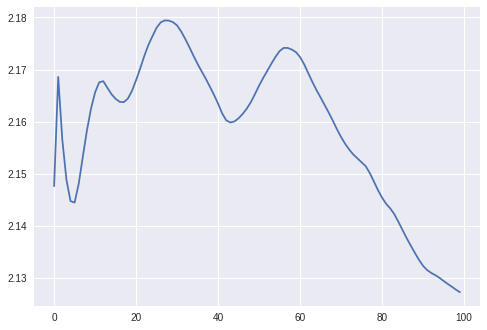

In [189]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()

Map token to corresponding word vector:

In [0]:
w = model.layer1.weight.detach().numpy().T

In [0]:
def index2vector(word_index):
    return w[word_index]

In [0]:
def word2vector(word):
    return w[batcher.word2index[word]]

### Visualization:

In [0]:
def reduce_to_k_dim(M, k=2):
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    
    svd = TruncatedSVD(n_components = k, n_iter = n_iters, random_state=42)
    M_reduced = svd.fit_transform(M)
    
    return M_reduced

In [193]:
print(w.shape)

(799, 16)


In [0]:
w_reduced = reduce_to_k_dim(w)

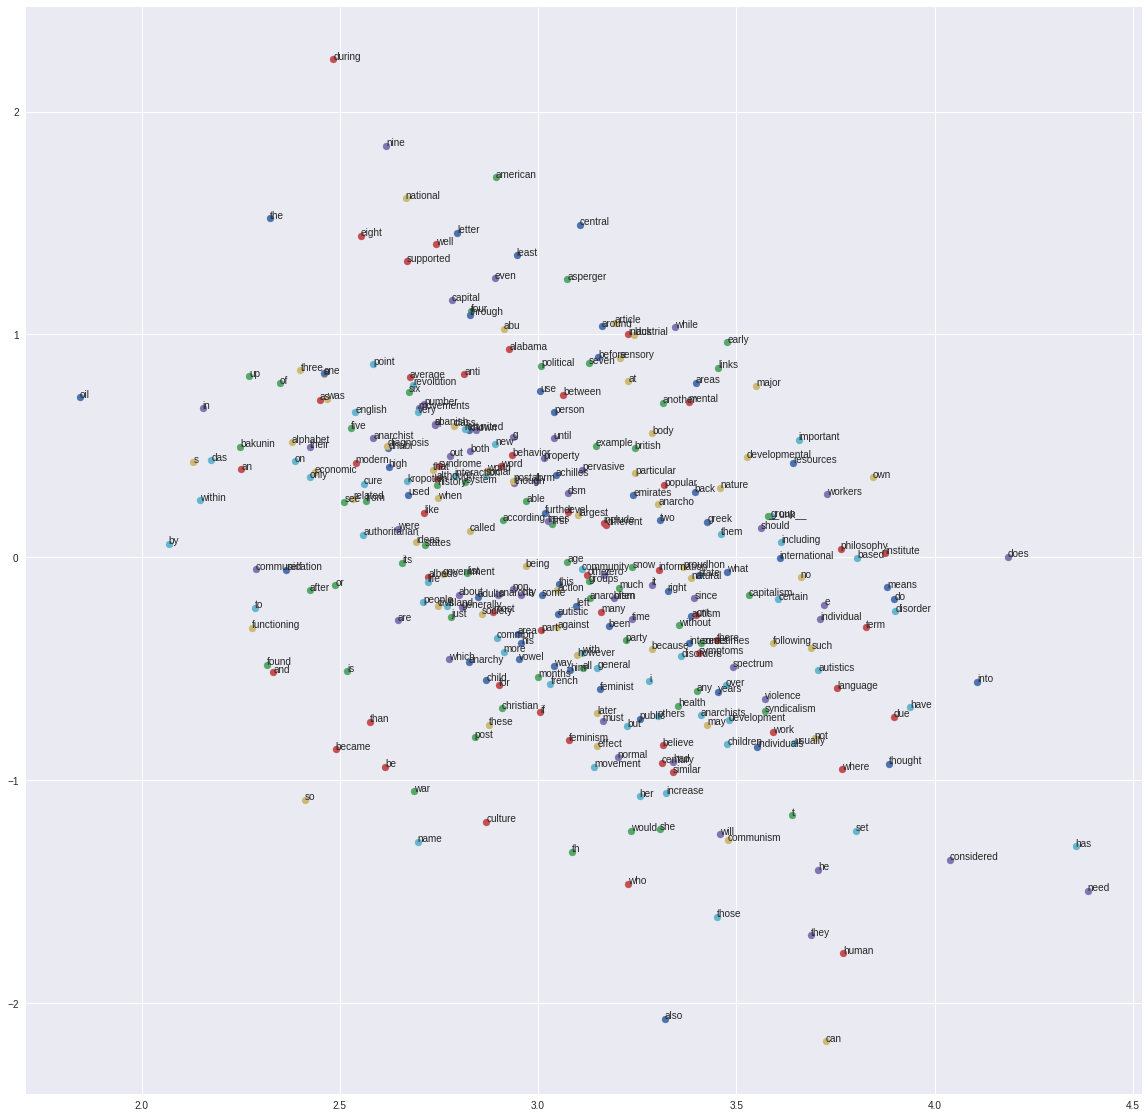

In [195]:
plt.figure(figsize = (20, 20))
x_list = w_reduced.T[0]
y_list = w_reduced.T[1]
word_list = np.array(batcher.remaining_words)
for x_, y_, word in zip(x_list, y_list, word_list):
    plt.scatter(x_, y_)
    plt.text(x_, y_, word, fontsize=10)
    
# plt.xlim((5.5, 6.5))
# plt.ylim((5.5, 6.5))
    
plt.show()

 Numbers are on the top of the cloud, but maybe it needs more time or more data to learn for a better result.

Qualitative evaluations of word vectors: 

In [0]:
def similar_words(word_index, quantity = 10):
    similarity = []
    word_v = index2vector(word_index)
    for i in range(batcher.vocab_size):
        if i != word_index:
            curr_v = index2vector(i)
            sim = word_v@curr_v
            norm = np.sqrt(word_v@word_v)*np.sqrt(curr_v@curr_v)
            
            similarity.append((i, sim/norm))
    similarity = sorted(similarity, key=lambda pair: pair[1], reverse=True)[:quantity]
    return similarity
    

#### Nearest neighbors:

In [203]:
word = batcher.word2index["seven"]

similarity = similar_words(word)
print("Word: ", batcher.index2word[word])
print("Similar words: ")
for sim_word in similarity:
    print(batcher.index2word[sim_word[0]], sim_word[1])

Word:  seven
Similar words: 
six 0.9604639
five 0.94919086
three 0.92830384
revolution 0.9155079
only 0.9129257
two 0.91112936
four 0.9104208
out 0.90569645
up 0.90398484
age 0.9032849


In [204]:
word = batcher.word2index["one"]

similarity = similar_words(word)
print("Word: ", batcher.index2word[word])
print("Similar words: ")
for sim_word in similarity:
    print(batcher.index2word[sim_word[0]], sim_word[1])

Word:  one
Similar words: 
from 0.90872973
up 0.89223385
until 0.8876878
three 0.8866011
seven 0.8757415
article 0.87401205
two 0.8702159
six 0.8655654
five 0.86170274
four 0.86083794


Quite good at predicting similar words

#### Word analogies:

In [0]:
  def analogy(positive_words, negative_words, quantity = 10):
    res_v = np.zeros(shape = index2vector(0).shape)
    for word in positive_words:
        res_v += word2vector(word)
        
    for word in negative_words:
        res_v -= word2vector(word)
        
    similarity = []
    
    for i in range(batcher.vocab_size):
        curr_v = index2vector(i)
        sim = res_v@curr_v
        norm = np.sqrt(res_v@res_v)*np.sqrt(curr_v@curr_v)
        similarity.append((i, sim/norm))
    similarity = sorted(similarity, key=lambda pair: pair[1], reverse=True)[:quantity]
    
    return similarity

In [209]:
positive_words = ["people", "child"]
negative_words = ["children"]
similarity = analogy(positive_words, negative_words)
for sim_word in similarity:
    print(batcher.index2word[sim_word[0]], sim_word[1])

people 0.913123598461017
states 0.8575655568581592
on 0.8160287728521103
from 0.8077230656997485
child 0.7891052738901857
information 0.7719935036173118
example 0.7690438983851418
became 0.7644227843683072
s 0.7633277604204471
developmental 0.7517864574358107


Unfortunately, the model has not learned to find analogies. It would be better if we trained in on the bigger corpus.